### 3. Data Augmentation

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import os
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

/home/todin/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-02-28 12:15:09.826597: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 12:15:09.911170: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 12:15:09.912249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 12:15:11.308173: W tensorflow/c

In [3]:
def read_and_crop(path):
    
    # Read the CSV file into a DataFrame
    if path[-1] == '/':
        df = pd.read_csv(path +'_annotations.csv')
    else :
        df = pd.read_csv(path +'/_annotations.csv')

    # Read and store cropped images
    cropped_image_list = []

    for index, row in df.iterrows():
        image_path = row['filename']
        if path[-1] == '/':
            image = Image.open(path + image_path)
        else :
            image = Image.open(path + '/' + image_path)
            

        # Extract cropping coordinates
        xmin, ymin, xmax, ymax = (
            max(0, row['xmin']),
            max(0, row['ymin']),
            min(image.width, row['xmax']),
            min(image.height, row['ymax'])
        )

        # Check if the adjusted coordinates are valid
        if xmin < xmax and ymin < ymax:
            
            # Crop the image
            cropped_image = np.array(image.crop((xmin, ymin, xmax, ymax))) 

            # Reshape the images in the 'cropped_image' column
            cropped_reshape_image = cv2.resize(cropped_image, (171, 138))

            # Store the cropped image in the list
            cropped_image_list.append(cropped_reshape_image)
        else:
            # If the coordinates are invalid, append a placeholder (e.g., None)
            cropped_image_list.append(None)

    # Add a new column to the DataFrame with cropped images
    df['cropped_image'] = cropped_image_list.copy()

    # Filter out rows with None values in the 'cropped_image' column
    df_valid_crops = df.dropna(subset=['cropped_image']).copy()
    
    df_final = df_valid_crops[['class', 'cropped_image']].copy()
    
    # 
    old_class_to_actual_class = {
        'tuna' : 'tuna', 
        'surgeon': 'surgeon', 
        'shark': 'shark', 
        'jack': 'jack', 
        'grouper': 'grouper', 
        'parrot': 'parrot', 
        'snapper': 'snapper',
        'damsel': 'damsel', 
        'trigger': 'trigger', 
        'Zanclidae (Moorish Idol)': 'moorish idol',
        'Scaridae -Parrotfishes-': 'parrot', 
        'Carangidae -Jacks-': 'jack',
        'Scombridae -Tunas-': 'tuna', 
        'Shark -Selachimorpha-': 'shark',
        'Serranidae -Groupers-': 'grouper', 
        'Lutjanidae -Snappers-': 'snapper',
        'Acanthuridae -Surgeonfishes-': 'surgeon', 
        'Pomacentridae -Damselfishes-': 'damsel',
        'Labridae -Wrasse-': 'wrasse', 
        'angel': 'angel', 
        'wrasse': 'wrasse', 
        'Zanclidae -Moorish Idol-': 'moorish idol',
        'Ephippidae -Spadefishes-': 'spade', 
        'Pomacanthidae -Angelfishes-': 'angel',
        'Balistidae -Triggerfishes-': 'trigger', 
        'spade': 'spade'
    }
   
    # Replace old class names with new class names
    df_final['class'] = df_final['class'].replace(old_class_to_actual_class)
    
    return df_final


def print_image_by_classes(df,images_to_plot=2):
    
    # Get unique classes in the DataFrame
    unique_classes = df['class'].unique()

    # Plot two random images for each class
    for class_name in unique_classes:
        # Filter DataFrame based on the current class
        df_same_class = df[df['class'] == class_name]

        # Check the number of images in the current class
        num_images = len(df_same_class)

        if num_images >= images_to_plot:
            # Randomly select two images from the current class
            random_indices = random.sample(df_same_class.index.tolist(), images_to_plot)

            # Plot the two random images for the current class
            fig, axes = plt.subplots(1, images_to_plot, figsize=(10, 5))
            fig.suptitle(f'Two Random Images of Class: {class_name}')

            for i, ax in enumerate(axes):
                ax.imshow(df_same_class.loc[random_indices[i]]['cropped_image'])
                ax.set_title(f"Index: {random_indices[i]}")
                ax.axis('off')

            plt.show()
            continue
            
        elif num_images >= 1:
            # Plot the single image for the current class
            plt.figure(figsize=(5, 5))
            plt.imshow(df_same_class.iloc[0]['cropped_image'])
            plt.title(f'Image of Class: {class_name} (Index: {df_same_class.index[0]})')
            plt.axis('off')
            plt.show()
            continue
            
        else:
            print(f"No images of class '{class_name}' for plotting.")
    

In [4]:
df_train = read_and_crop('data/train/')
df_test = read_and_crop('data/test/')
df_valid = read_and_crop('data/valid/')

In [5]:
# function to ressort the X and y of dataframe
def to_work(df):
    
    class_to_number = {
    'tuna': 0, 
    'surgeon': 1, 
    'shark': 2, 
    'jack': 3, 
    'grouper': 4, 
    'parrot': 5, 
    'snapper': 6,
    'damsel': 7, 
    'trigger': 8, 
    'moorish idol': 9, 
    'wrasse': 10, 
    'angel': 11, 
    'spade': 12
}

    X = np.stack(df['cropped_image'].to_numpy().copy(), axis=0)
    
    # standardize and center data (make my pc crash)
    X = (X / 255) - 0.5
    
    y = df['class'].replace(class_to_number).to_numpy().copy()
    y_cat = to_categorical(y, num_classes=13)  
    
    return X, y, y_cat 

In [6]:
X_train, y_train, y_train_cat = to_work(df_train)
X_test, y_test, y_test_cat = to_work(df_test)
X_val, y_val, y_val_cat = to_work(df_valid)

In [7]:
X_train.shape

(2075, 138, 171, 3)

In [8]:
y_train.shape

(2075,)

In [9]:
def over_undersampling(X, y, st=376):
    
    # Reshape each image to a flat vector
    X_flat = X.reshape(X.shape[0], -1)

        # summarize class distribution
    print(f"Original class distribution: {Counter(y)}")

    oversample = RandomOverSampler(sampling_strategy={7:st,8:st,9:st,10:st,11:st,12:st})
    undersample = RandomUnderSampler(sampling_strategy={1:st})

        # Fit and apply the transform
    X_over, y_over = oversample.fit_resample(X_flat, y)
    X_under, y_under = undersample.fit_resample(X_over, y_over)
        # Summarize class distribution after oversampling
    print(f"Class distribution after sampling: {Counter(y_under)}")

        # Reshape the resampled data back to the original image shape
    X_resampled = X_under.reshape(-1, 138, 171, 3)
    X, y = X_resampled, y_under

    return X_resampled, y_under



In [10]:
X_resampled, y_resampled = over_undersampling(X_train, y_train, st=376)

Original class distribution: Counter({1: 534, 3: 376, 0: 333, 6: 299, 2: 188, 5: 176, 4: 147, 7: 12, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2})


Class distribution after sampling: Counter({1: 376, 3: 376, 7: 376, 8: 376, 9: 376, 10: 376, 11: 376, 12: 376, 0: 333, 6: 299, 2: 188, 5: 176, 4: 147})


In [11]:
def init_model():
    
    # Start by creating a sequential model
    model = models.Sequential()
    
    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8, (4, 4), activation='relu', padding='same', input_shape=(138, 171, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    ### Second Convolution & MaxPoolingialize
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer
    model.add(layers.Dense(25, activation='relu'))
    # droupout to minimise the overfitting
    model.add(layers.Dropout(0.3))
    ### Last layer - Classification Layer
    model.add(layers.Dense(13, activation='softmax')) # softmax for multiclass classification

    ### Model compilation
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'Precision','Recall'])
    
    return model

In [12]:
# to plot the result
def plot_history(history):
    fig, axs = plt.subplots(4,1, figsize=(10,10))
    
    axs[0].plot(history.history['loss'], color='red', label='train')
    axs[0].plot(history.history['val_loss'], color='blue', label='val')
    axs[0].set_title('Loss')
    axs[0].legend(['train', 'validation'],loc="upper right")
    
    axs[1].plot(history.history['accuracy'], color='red', label='train')
    axs[1].plot(history.history['val_accuracy'], color='blue', label='val')
    axs[1].set_title('Accuracy ')
    axs[1].legend(['train', 'validation'],loc="upper right")

    axs[2].plot(history.history['precision'], color='red', label='train')
    axs[2].plot(history.history['val_precision'], color='blue', label='val')
    axs[2].set_title('Precision ')
    axs[2].legend(['train', 'validation'],loc="upper right")

    axs[3].plot(history.history['recall'], color='red', label='train')
    axs[3].plot(history.history['val_recall'], color='blue', label='val')
    axs[3].set_title('Recall')
    axs[3].legend(['train', 'validation'],loc="upper right")
    

    for ax in axs.flat:
        ax.set(xlabel='Epoch', ylabel='')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        
    plt.show()

In [13]:
y_resampled_cat=to_categorical(y_resampled, num_classes=13) 

2024-02-28 12:15:33.127667: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-02-28 12:15:33.127715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: Todin-s-laptop
2024-02-28 12:15:33.127727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: Todin-s-laptop
2024-02-28 12:15:33.128390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.147.5
2024-02-28 12:15:33.128436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.147.5
2024-02-28 12:15:33.128447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.147.5
2024-02-28 12:15:40.611787: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1175463576 exceeds 10% of free system memo

------------------------------------------Batch Size 16------------------------------------------


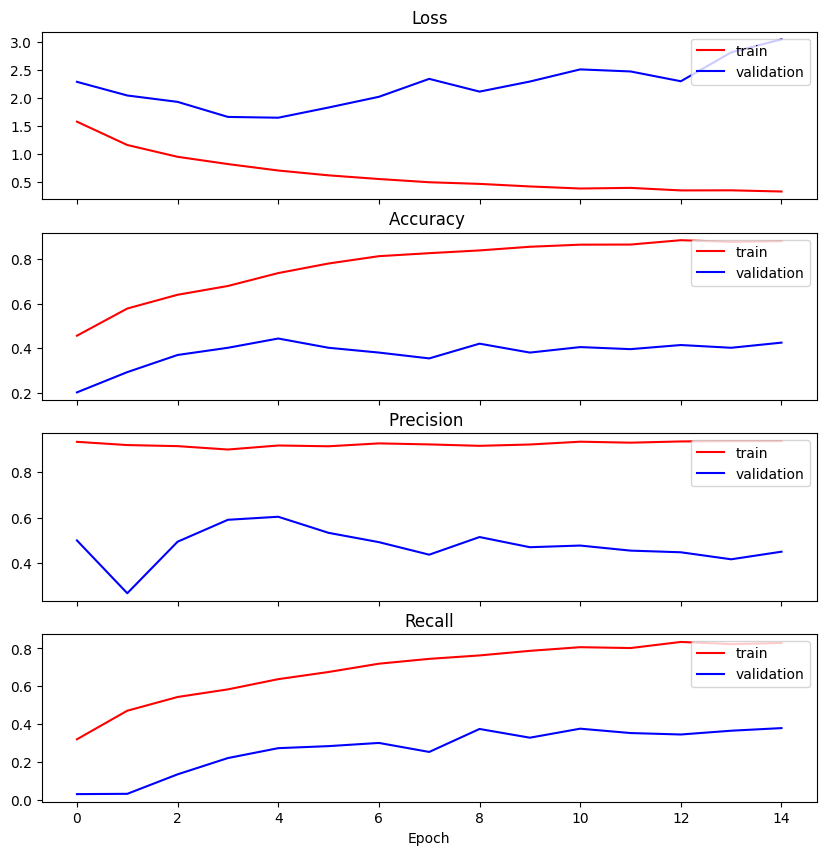

2024-02-28 12:22:13.957193: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1175463576 exceeds 10% of free system memory.


         Model Evaluation on Training :
     Training Loss:     0.3439134359359741
   Training Accuracy:   0.8925560116767883
  Training Precision:   0.979136049747467
    Training Recall:    0.8026981353759766 

         Model Evaluation on Validation :
    Validation Loss:    1.653304934501648
  Validation Accuracy:  0.4439324140548706
 Validation Precision:  0.6033898591995239
   Validation Recall:   0.27342548966407776


In [14]:
# to save the models & the metrics
models_cnn = {}

# early stopping critera
es = EarlyStopping(patience=10, restore_best_weights=True)


    
model = init_model()
    
history = model.fit(
    X_resampled,
    y_resampled_cat,
    validation_data=(X_val, y_val_cat),
    epochs = 100,
    batch_size = 16, 
    verbose = 0, 
    callbacks = [es]
)
    
print(f'------------------------------------------Batch Size {16}------------------------------------------')
    
# store the model
models_cnn[16] = model
        
# plot the history of loss and accuracy
plot_history(history)
    
# print the evaluation of the model:
trainEval = model.evaluate(X_resampled,y_resampled_cat, verbose=0)
valEval = model.evaluate(X_val,y_val_cat, verbose=0)

print("         Model Evaluation on Training :")
print("     Training Loss:    ", trainEval[0])
print("   Training Accuracy:  ", trainEval[1])
print("  Training Precision:  ", trainEval[2])
print("    Training Recall:   ", trainEval[3], '\n')
print("         Model Evaluation on Validation :")
print("    Validation Loss:   ", valEval[0])
print("  Validation Accuracy: ", valEval[1])
print(" Validation Precision: ", valEval[2])
print("   Validation Recall:  ", valEval[3])
